<a href="https://colab.research.google.com/github/eadewusic/Ekonify/blob/main/Summative_Intro_to_ml_%5BEunice_Adewusi%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency.


## Project Details

* **Name:** Ekonify
* **Aim:** To develop a machine learning-based waste classification system using publicly available datasets, demonstrating the applicability of AI in addressing urban waste challenges and optimising recycling processes.
* **Project Goal:** To develop an AI-powered waste classification system that can automatically identify and categorize waste into predefined classes, improving recycling efficiency and environmental sustainability.


**Dataset Used:** https://www.kaggle.com/datasets/mostafaabla/garbage-classification?select=garbage_classification


# Case Study and Implementation




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 92% 221M/239M [00:02<00:00, 102MB/s] 
100% 239M/239M [00:02<00:00, 95.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('garbage-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
#Import Necessary Libraries
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image, ImageOps
from glob import glob
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models, Input, regularizers
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# The Dataset

#### **Problem Statement**  
According to the World Bank's What a Waste 2.0 report, low-income countries often have recycling rates below 5%, compared to high-income countries where rates exceed 40%. Lagos faces similar challenges due to a growing population and limited waste management infrastructure. Manual sorting is time-consuming, costly, and prone to errors, while public unawareness worsens inefficiencies. While studies like TrashNet and Garbage Type Detection demonstrate the potential of machine learning in waste classification, their reliance on generalised datasets limits their adaptability to specific regions like Lagos. Additionally, these solutions lack integration with public engagement platforms, which are crucial for driving scalable, community-wide impact. How can AI bridge the gap in Lagos' waste management system and catalyse a greener, more sustainable future for its 20+ million residents?

#### **Dataset Description**  
The **"Garbage Classification (12 classes)"** dataset contains images of various types of waste categorized into 12 distinct classes. These categories represent common waste types found in recycling and disposal systems. The dataset is designed for training machine learning models, particularly deep learning models like Convolutional Neural Networks (CNNs), to classify waste accurately.  

**Key Features of the Dataset:**  
- **Number of Classes:** 12  
- **Waste Categories:**  
  - Battery  
  - Biological  
  - Brown Glass  
  - Cardboard  
  - Clothes  
  - Green Glass  
  - Metal  
  - Paper  
  - Plastic  
  - Shoes  
  - Trash  
  - White Glass  
- **Image Format:** RGB (3 channels)  
- **Typical Image Size:** Can be resized to **224x224x3** for CNN input  
- **Use Case:** Automated waste classification for recycling and environmental sustainability  

This dataset provides a solid foundation for building an AI-powered waste sorting system, helping reduce pollution and improve waste management processes.

In [ ]:
dataset_path = "/content/garbage_classification"

# Find image files inside all subfolders
image_files = glob(os.path.join(dataset_path, "*", "*.jpg")) + \
              glob(os.path.join(dataset_path, "*", "*.png")) + \
              glob(os.path.join(dataset_path, "*", "*.jpeg"))

if not image_files:
    print("No images found in subfolders.")
else:
    print(f"Found {len(image_files)} images.")

# Use the first image
first_image_path = image_files[0]
print("First image path:", first_image_path)

Found 15515 images.
First image path: /content/garbage_classification/brown-glass/brown-glass321.jpg


Image Size: (200, 252)
Number of Channels: 3
Found 15515 files belonging to 12 classes.
Batch size 16 works!
Found 15515 files belonging to 12 classes.
Batch size 32 works!
Found 15515 files belonging to 12 classes.
Batch size 64 works!


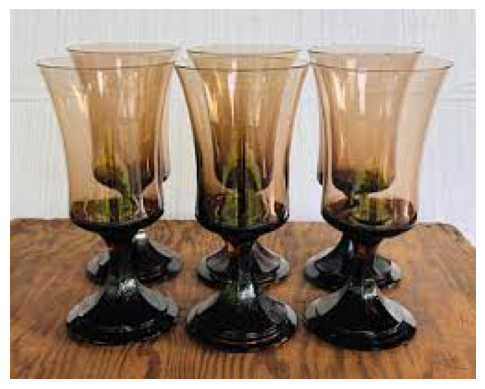

In [ ]:
# Load the first image
image = cv2.imread(first_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Get dimensions
IMAGE_SIZE = image.shape[:2]  # (height, width)
CHANNELS = image.shape[2]  # Number of channels

print("Image Size:", IMAGE_SIZE)
print("Number of Channels:", CHANNELS)

# Test batch sizes
for batch in [16, 32, 64]:
    try:
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_path,
            image_size=IMAGE_SIZE,
            batch_size=batch
        )
        print(f"Batch size {batch} works!")
    except:
        print(f"Batch size {batch} is too large!")

# Show the image
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
# Image dimensions
IMAGE_SIZE = (224, 224)  # Standardizing to 224x224
CHANNELS = 3  # RGB images
BATCH_SIZE = 32

In [ ]:
# Dataset directory
dataset_path = "/content/garbage_classification"

# Load training & validation datasets
train_dataset = image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),  # Forces resizing to (224, 224)
    batch_size=32  # Ensure batch size is correct
)

val_dataset = image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),  # Forces resizing
    batch_size=32
)

# Print class names (categories)
class_names = train_dataset.class_names
print("Classes:", class_names)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.
Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [ ]:
#The length of the dataset
len(dataset)

243

In [ ]:
#A batch of 32 and each image now has size of 224 * 224 pixels
for image_batch, label_batch in train_dataset.take(1):
  print("Image batch shape:", image_batch.shape)
  print("Label batch shape:", label_batch.shape)
  print(label_batch.numpy())

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
[ 5  0  9  4  7  8  9  1  3  4  8  1  7  8  0 10 10  7  4  0  4  4  5  7
  5  4  9  4  4  1  8  9]


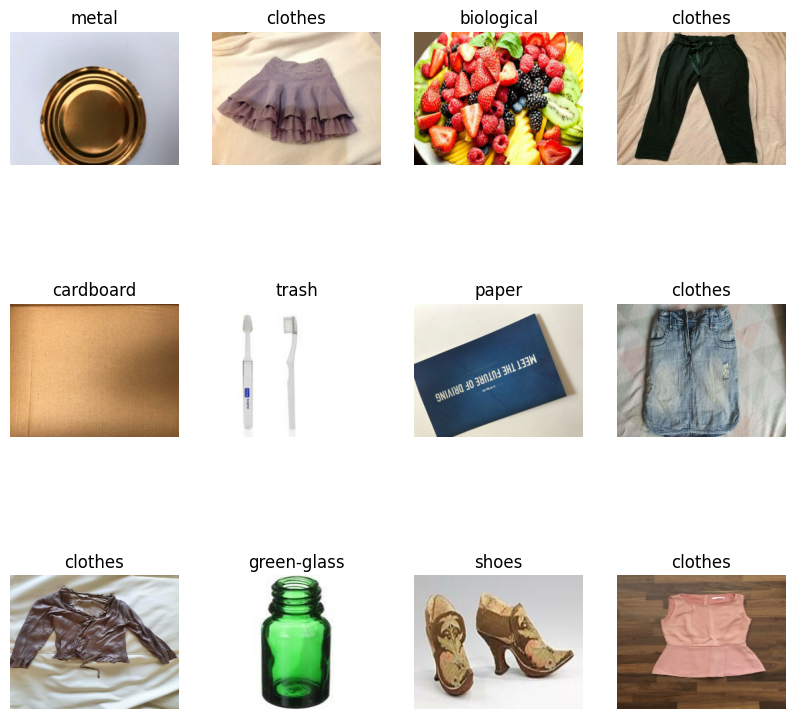

In [ ]:
#Viewing first 12 images in the batch
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
# Normalize the pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
# Split training dataset further to create a test set
test_size = int(0.1 * len(train_dataset))
test_dataset = train_dataset.take(test_size)
train_dataset = train_dataset.skip(test_size)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 350
Validation samples: 97
Test samples: 38


In [ ]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

# Apply to training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#SECTION 1: Model Architecture:

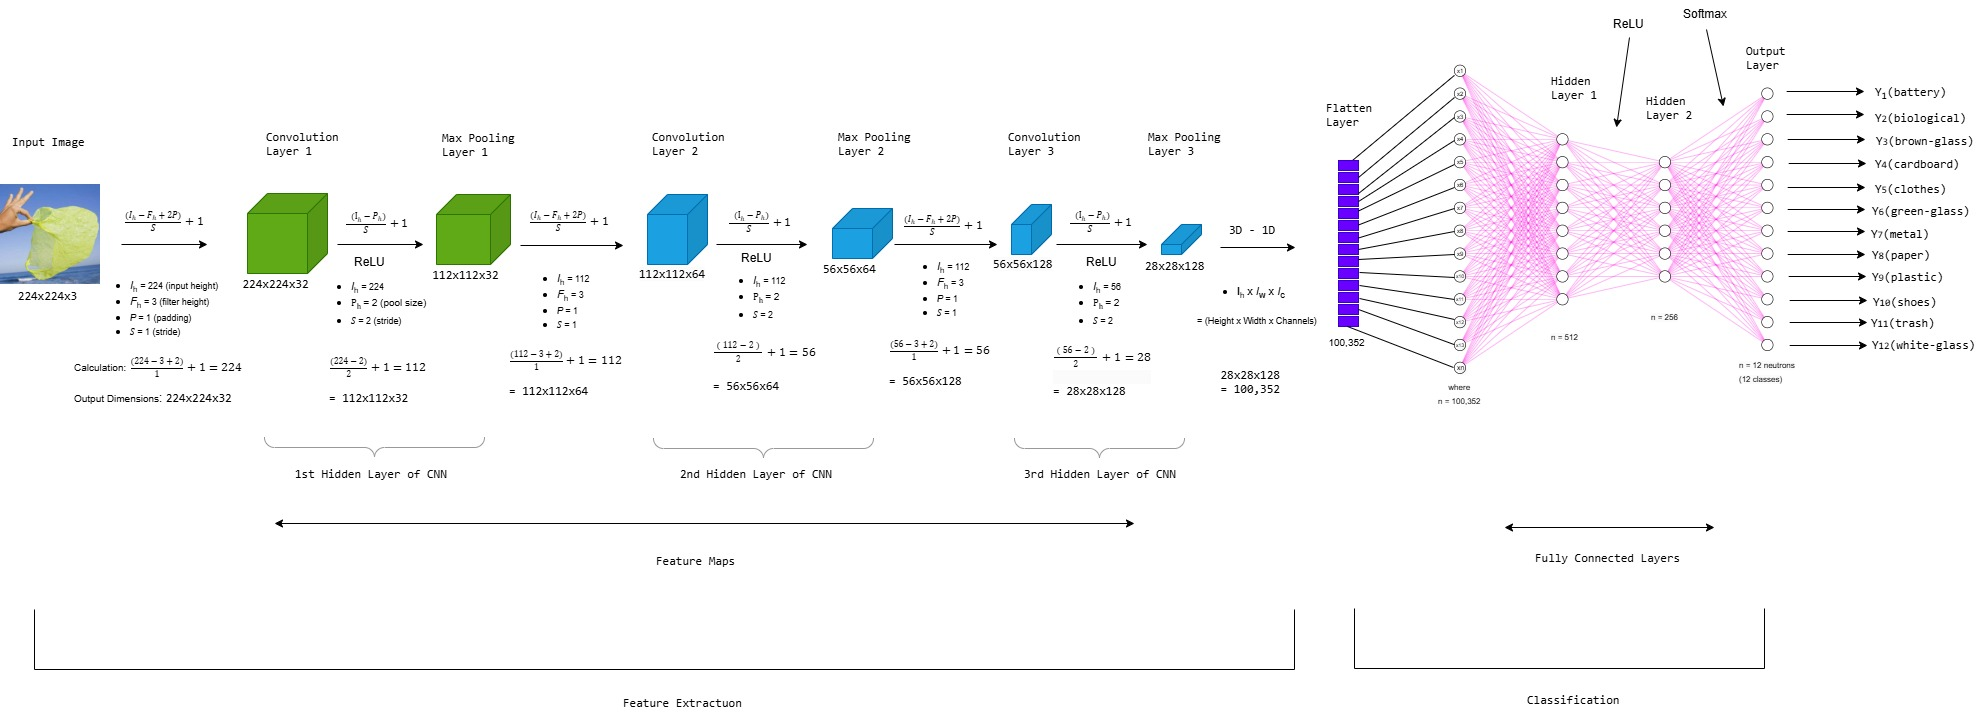


#Task: Define a function that creates models without and With specified Optimization techniques


## **Model 1: Baseline CNN (No Optimization)**
Starting with a simple CNN as a baseline.

In [ ]:
def create_baseline_model():
    model = models.Sequential([
        Input(shape=(224, 224, 3)),  # Explicit Input Layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')  # Output layer
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Instantiate the model
baseline_model = create_baseline_model()
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,508 (42.61 MB)

 Trainable params: 11,170,508 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_baseline = baseline_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Keep epochs low for the baseline
)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1427s 4s/step - accuracy: 0.4047 - loss: 1.9607 - val_accuracy: 0.5727 - val_loss: 1.2536
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1393s 4s/step - accuracy: 0.6056 - loss: 1.1963 - val_accuracy: 0.6352 - val_loss: 1.1297
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1392s 4s/step - accuracy: 0.6378 - loss: 1.0927 - val_accuracy: 0.6275 - val_loss: 1.0783
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1396s 4s/step - accuracy: 0.6530 - loss: 1.0341 - val_accuracy: 0.6452 - val_loss: 1.0669
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1380s 4s/step - accuracy: 0.6810 - loss: 0.9557 - val_accuracy: 0.6632 - val_loss: 1.0328
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1367s 4s/step - accuracy: 0.6971 - loss: 0.9102 - val_accuracy: 0.6797 - val_loss: 0.9918
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1397s 4s/step - accuracy: 0.7138 - loss: 0.8609 - val_accuracy: 0.6387 - val_loss: 1.1449
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1321s 4s/step - accuracy: 0.7113 - loss: 0.8524 - 

In [ ]:
# check model's performance on unseen test data after training
test_perf_baseline = baseline_model.evaluate(test_dataset)
print(f"Baseline Model - Test Loss: {test_perf_baseline[0]}, Test Accuracy: {test_perf_baseline[1]}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6990 - loss: 0.8878
Baseline Model - Test Loss: 0.8418061137199402, Test Accuracy: 0.7088815569877625


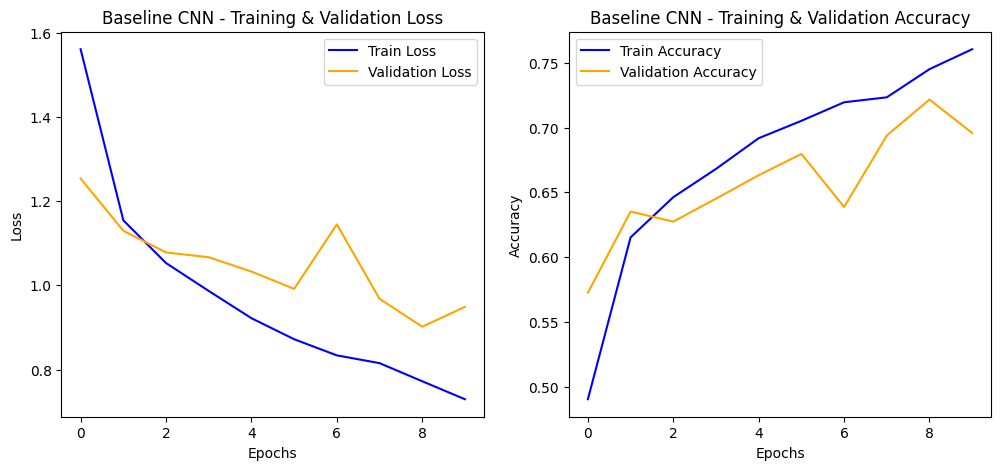

In [ ]:
# Improved Training & Validation Plot
def plot_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))

    # Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training & Validation Loss')
    plt.legend()

    # Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training & Validation Accuracy')
    plt.legend()

    plt.show()

# Plot the graphs
plot_history(history_baseline, "Baseline CNN")

First image to predict:
Actual label on dataset: clothes
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label by model: clothes


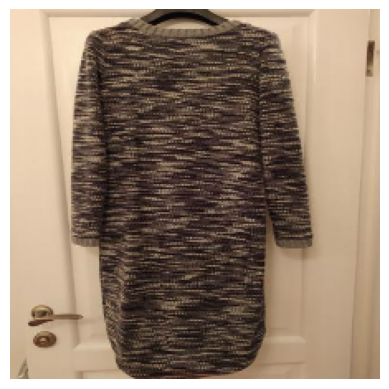

In [ ]:
# Making a single prediction
for images_batch, labels_batch in test_dataset.take(1):
    img_1 = images_batch[0].numpy()  # Remove 'uint8' conversion so image can retain [0, 1] instead of [0, 255]
    img1_label = labels_batch[0].numpy()

    print('First image to predict:')
    plt.imshow(img_1)
    print('Actual label on dataset:', class_names[img1_label])

    batch_prediction = baseline_model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]

    print('Predicted label by model:', predicted_label)
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


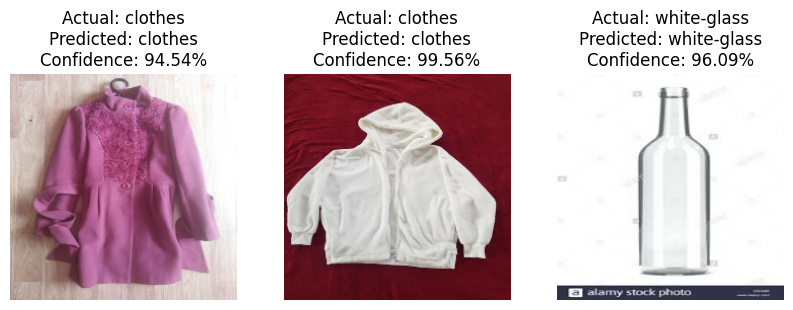

In [ ]:
# Making more predictions
def predict(model, img):
    # Convert image to array and expand dims for prediction
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Model expects batch format

    predictions = baseline_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence_level = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence_level

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(3):  # Predict for 3 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())

        predicted_class, confidence_level = predict(baseline_model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]  # Ensure correct label index

        plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence_level}%')
        plt.axis("off")

plt.show()

In [ ]:
#Since Baseline CNN is a Keras model, the best way to save it is using the .keras format

# Create the directory if it doesn't exist
os.makedirs("saved_models", exist_ok=True)

# Now save the model
baseline_model.save("saved_models/baseline_cnn.keras")

In [ ]:
print("Saved models:", os.listdir("saved_models"))

Saved models: ['baseline_cnn.keras']


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/ste

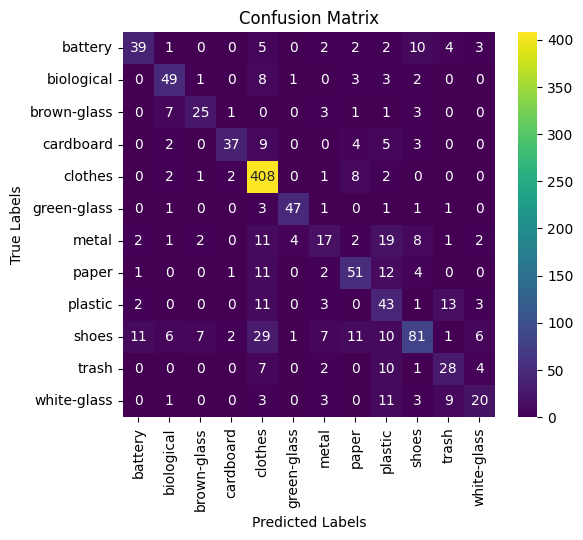

In [ ]:
#Error Analysis visualization

# Step 1: Get true labels and predictions from the test set
y_true = []
y_pred = []

# Collect true labels and predictions
for images, labels in test_dataset:
    preds = baseline_model.predict(images)  # Predict class probabilities
    y_true.extend(labels.numpy().astype(int))  # Convert true labels to int
    y_pred.extend(np.argmax(preds, axis=1))  # Get predicted class index

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Step 3: Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Step 4: Model Performance Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print performance metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")

# Step 5: Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## **Model 2: Optimized CNN**
Improving my model architecture with added optimizations:

* Adam Optimizer with a tunable learning rate
* L2 Regularization on Conv & Dense layers
* Dropout layers to prevent overfitting
* Early Stopping to stop training when validation loss stops improving
* Epoch tuning with a ReduceLROnPlateau scheduler


In [ ]:
# Define model function with optimizations
def create_optimized_model(initial_lr=0.0005, dropout_rate=0.4, l2_lambda=0.0005):
    inputs = keras.Input(shape=(224, 224, 3))  # Define input layer

    # Convolutional Block 1
    x = layers.Conv2D(32, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(l2_lambda))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 2
    x = layers.Conv2D(64, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 3
    x = layers.Conv2D(128, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer 1
    x = layers.Dense(512, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    # Fully Connected Layer 2
    x = layers.Dense(256, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output Layer (12 classes)
    outputs = layers.Dense(12, activation='softmax')(x)

    # Build Model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile Model with AdamW optimizer
    model.compile(
        optimizer=AdamW(learning_rate=initial_lr, weight_decay=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the optimized model
optimized_model = create_optimized_model()

# Learning Rate Scheduler (Reduces LR dynamically)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1)

# Early Stopping (Triggers Earlier for Shorter Training)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Apply Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

optimized_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 297,676 (1.14 MB)

 Trainable params: 295,692 (1.13 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# Extract labels from train_dataset
y_train = np.concatenate([y.numpy() for _, y in train_dataset])

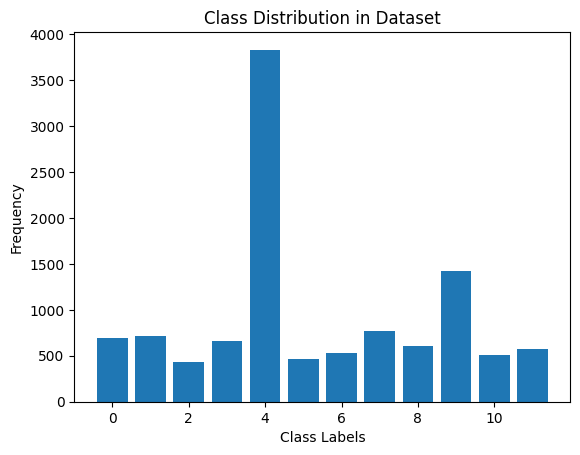

In [ ]:
# Get class distribution from labels
unique, counts = np.unique(y_train, return_counts=True)

# Plot class distribution
plt.bar(unique, counts)
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Class Distribution in Dataset")
plt.show()

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary (ensure correct mapping)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: 1.3561046511627908, 1: 1.3103932584269662, 2: 2.135011441647597, 3: 1.4157814871016692, 4: 0.24360313315926893, 5: 2.0238611713665944, 6: 1.75046904315197, 7: 1.2180156657963446, 8: 1.5472636815920398, 9: 0.6584333098094566, 10: 1.8258317025440314, 11: 1.61139896373057}


In [ ]:
# Train Model
history_optimized = optimized_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=21,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict  # Add computed class weights
)

Epoch 1/21
350/350 ━━━━━━━━━━━━━━━━━━━━ 2366s 7s/step - accuracy: 0.3799 - loss: 2.6949 - val_accuracy: 0.2862 - val_loss: 2.9694 - learning_rate: 5.0000e-04
Epoch 2/21
350/350 ━━━━━━━━━━━━━━━━━━━━ 2367s 7s/step - accuracy: 0.4575 - loss: 2.4083 - val_accuracy: 0.4876 - val_loss: 2.2649 - learning_rate: 5.0000e-04
Epoch 3/21
350/350 ━━━━━━━━━━━━━━━━━━━━ 2400s 7s/step - accuracy: 0.4890 - loss: 2.2481 - val_accuracy: 0.4434 - val_loss: 2.3960 - learning_rate: 5.0000e-04
Epoch 4/21
350/350 ━━━━━━━━━━━━━━━━━━━━ 2368s 7s/step - accuracy: 0.5204 - loss: 2.1084 - val_accuracy: 0.5372 - val_loss: 2.0589 - learning_rate: 5.0000e-04
Epoch 5/21
350/350 ━━━━━━━━━━━━━━━━━━━━ 2430s 7s/step - accuracy: 0.5391 - loss: 2.0111 - val_accuracy: 0.4521 - val_loss: 2.2714 - learning_rate: 5.0000e-04
Epoch 6/21
350/350 ━━━━━━━━━━━━━━━━━━━━ 2405s 7s/step - accuracy: 0.5519 - loss: 1.9448 - val_accuracy: 0.5840 - val_loss: 1.9408 - learning_rate: 5.0000e-04
Epoch 7/21
350/350 ━━━━━━━━━━━━━━━━━━━━ 2351s 7s/ste

In [ ]:
# check model's performance on unseen test data after training
test_perf_optimize = optimized_model.evaluate(test_dataset)
print(f"Optimized Model - Test Loss: {test_perf_optimize[0]}, Test Accuracy: {test_perf_optimize[1]}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 996ms/step - accuracy: 0.4650 - loss: 1.7500
Optimized Model - Test Loss: 1.7220189571380615, Test Accuracy: 0.47039473056793213


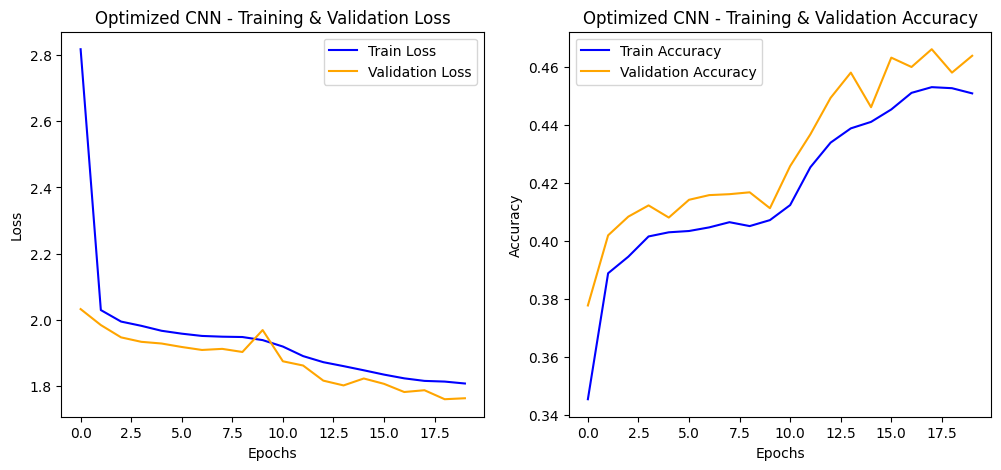

In [ ]:
# Improved Training & Validation Plot
def plot_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))

    # Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training & Validation Loss')
    plt.legend()

    # Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training & Validation Accuracy')
    plt.legend()

    plt.show()

# Plot the graphs
plot_history(history_optimized, "Optimized CNN")

In [ ]:
# Making a single prediction
for images_batch, labels_batch in test_dataset.take(1):
    img_1 = images_batch[0].numpy()  # Remove 'uint8' conversion so image can retain [0, 1] instead of [0, 255]
    img1_label = labels_batch[0].numpy()

    print('First image to predict:')
    plt.imshow(img_1)
    print('Actual label on dataset:', class_names[img1_label])

    batch_prediction = optimized_model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]

    print('Predicted label by model:', predicted_label)
    plt.axis("off")
    plt.show()

## **Model 3: Classical ML Model (Logistic Regression)**
Using Logistic Regression to compare deep learning vs traditional ML.

In [ ]:
# Extract features using the trained CNN (Feature Extraction)
def extract_features(model, dataset):
    features, labels = [], []
    for images, lbls in dataset:
        features.append(model.predict(images))  # Extract CNN features
        labels.append(lbls.numpy())

    return tf.concat(features, axis=0).numpy(), tf.concat(labels, axis=0).numpy()

# Get features from CNN (without softmax layer)
feature_extractor = tf.keras.Model(inputs=optimized_model.input, outputs=optimized_model.layers[-2].output)

X_train, y_train = extract_features(feature_extractor, train_dataset)
X_val, y_val = extract_features(feature_extractor, val_dataset)

# Train Logistic Regression on CNN-extracted features
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
log_reg.fit(X_train, y_train)

# Evaluate Model
y_pred = log_reg.predict(X_val)
print(classification_report(y_val, y_pred))

NameError: name 'optimized_model' is not defined

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizer
from tensorflow.keras.callbacks import EarlyStopping


def define_model(optimization: string, regularization_datatype, early_stopping: bool, dropout: float, learning_rate: float):
  model= None
  model.add(None)
  #TO DO: Add more layers as per architecture
  model.add(None) # Last Layer
  model.compile(optimizer = optimizerNone)
  model.fit(None)
  return model

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [ ]:
def loss_curve_plot():
  epochs = 9
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [ ]:
#TODO:
model_2 = define_model('Adam', None)
loss_curve_plot(model_2):
#print out confusion matrix and error analysis metrics after the cell

In [ ]:
#TODO:
model_3 = define_model('RMSPop',None)
loss_curve_plot(model_3):
#print out confusion matrix and error analysis metrics after the cell

In [ ]:
#TODO:
model_4 = define_model(None)
loss_curve_plot(model_4):
#print out confusion matrix and error analysis metrics after the cell

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
def make_predictions(model_path, X):

    # Load the model
    model = load_model(None)
    # Make predictions
    predictions = None
    # Convert probabilities to binary labels (0 or 1)

    return predictions

#Modify the code appropriately

In [ ]:
model_path = None
make_predictions(None)

Congratulations!!
